In [71]:
import pandas as pd
import numpy as np
from numpy import expand_dims
import math
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.utils import to_categorical
import tensorflow as tf
from  keras.utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Transfert Learning
from keras.applications.vgg16 import VGG16
from keras.layers import Dense
from keras import Model
from keras.optimizers import Adam,Nadam, SGD

"""
2.1.3   -   Deep Approach - Data Augmentation 
"""
def plot_accuracy_evolution(history):
    plt.figure(figsize=(20, 5))
    plt.plot(history.history['accuracy'], label = 'train')
    plt.plot(history.history['val_accuracy'], label = 'valid')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

def plot_model_evolution(history):
    # Learning curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    
def import_measures():
    filename = 'WangSignatures.xlsx'

    # Load the JCD, PHOG, CEDD, FCTH, and Fuzzy Color Histogram measurements from the excel file
    jcd_df = pd.read_excel(filename, sheet_name='WangSignaturesJCD', header=None)
    phog_df = pd.read_excel(filename, sheet_name='WangSignaturesPHOG', header=None)
    cedd_df = pd.read_excel(filename, sheet_name='WangSignaturesCEDD', header=None)
    fcth_df = pd.read_excel(filename, sheet_name='WangSignaturesFCTH', header=None)
    fuzzy_df = pd.read_excel(filename, sheet_name='WangSignaturesFuzzyColorHistogr', header=None)

    # Concatenate the dataframes into a single dataframe
    data_df = pd.concat([jcd_df, phog_df, cedd_df, fcth_df, fuzzy_df], axis=1)
    return data_df

def cnn_model_wang_images(image_folder, file_extension, epochs):
    # Load dataset and resize images to the same size
    images_labels = []
    images = []
    image_width = 256
    image_height = 256
    for filename in os.listdir(image_folder):
        if filename.__contains__(file_extension): 
            img = cv2.resize(img_to_array(load_img(image_folder+'/'+filename)), (image_width, image_height))
            images.append(img)
            image_label = math.ceil(int(filename.split('.')[0]) / 100)  # Extract the label from the filename
            images_labels.append(image_label)
            #print(filename, image_label)

    # Convert the labels to one-hot encoding
    images_labels = to_categorical(images_labels)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, images_labels, test_size=0.2, random_state=42)

    X_train = np.asarray(X_train).astype('float32')
    X_test = np.asarray(X_test).astype('float32')
    y_train = np.asarray(y_train).astype('float32') #.reshape((-1,1))
    y_test = np.asarray(y_test).astype('float32') #.reshape((-1,1))

    print('\t○\tShapes of training and testing datasets')
    print(X_train.shape , X_test.shape, y_train.shape, y_test.shape)

    # Define the model
    model = tf.keras.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(11, activation='sigmoid'))


    # Summary of the model
    print('\t○\tModel Summary')
    model.summary()

    # Compile the model
    print('\t○\tModel Compilation')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model on the training set
    history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

    #plot_accuracy_evolution(history)

    # Evaluate the model on the testing set
    print('\t○\tModel Evalutation')
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)

    return images, images_labels, model, X_train, y_train, X_test, y_test, history

def data_augmentation(images):
    for i in range(1000):
        # Expanding dimension to one sample
        samples = expand_dims(images[i], 0)

        # Calling ImageDataGenerator for creating data augmentation generator.
        datagen = ImageDataGenerator(
            #rotation_range=90
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
            )

        # Creating an iterator for data augmentation
        it = datagen.flow(samples, batch_size=1)

        # Preparing the Samples and Plot for displaying output
        for j in range(9):
            # preparing the subplot
            #plt.subplot(330 + 1 + i)
            plt.figure(figsize=(2.56, 2.56), dpi=100)

            # generating images in batches
            batch = it.next()
            # Remember to convert these images to unsigned integers for viewing 
            image = batch[0].astype('uint8')
            # Plotting the data
                #hide axes and borders
            plt.axis('off')
            plt.imshow(image)
            plt.savefig('Wang_Data_Augmentation/' + str(i) + '.' + str(j) + '.png')
            plt.close()
            
        # Displaying the figure
        #plt.show()
        plt.close()

def transfert_learning(X_train, y_train, X_test, y_test,  num_classes, epochs):
    print('\t○\tTransfert Learning avec VGG16')
    # Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
    model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
    
    # Architecture du model
    model.summary()
    
    # Récupérer la sortie de ce réseau
    x = model.output

    # Ajouter la nouvelle couche fully-connected pour la classification à 10 classes
        # Flatten the output of the base model
    x = Flatten()(x)
        # Add a new fully-connected layer with 256 units and ReLU activation
    x = Dense(256, activation='relu')(x)
        # Add a new fully-connected layer with 256 units and ReLU activation
    x = Dense(256, activation='relu')(x)
        # Add a new output layer with num_classes units and softmax activation
    predictions = Dense(num_classes, activation='softmax')(x)

    # Définir le nouveau modèle
 #   new_model = Model(inputs=model.input, outputs=predictions)
    new_model = Model(inputs=model.input, outputs=predictions)

    # 1. Fine tuning : Ici, on entraîne tout le réseau, donc il faut rendre toutes les couches "entraînables"
    #for layer in model.layers:
    #    layer.trainable = True
    
    # 2. Feature extraction: On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches
    for layer in model.layers:
        layer.trainable = False
    #new_model.layers[:-3].trainable = False

    # 3. fine-tuning partiel: On entraîne le nouveau classifieur et les couches hautes
        # Ne pas entraîner les 3 premières couches (les plus basses) 
    #for layer in model.layers[:3]:
    #    layer.trainable = False

    # Compiler le modèle 
    new_model.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])

    # Entraîner sur les données d'entraînement (X_train, y_train)
    model_info = new_model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=2)
      
    # training the model
    loss0, accuracy0 = new_model.evaluate(X_test, y_test)

    print("initial loss: {:.2f}".format(loss0))
    print("initial accuracy: {:.2f}".format(accuracy0))
    
    history = new_model.fit((X_train, y_train), epochs=epochs, validation_data=(X_test, y_test))

    plot_model_evolution(history)

    return new_model, model_info, history

In [27]:
    
print('•\tMeasurement Importation')
data_df = import_measures()
print('•\tMeasurement Importation: OK')

•	Measurement Importation
•	Measurement Importation: OK


In [75]:

print('•\tCNN Model on Wang images')
# Load the images and their corresponding labels
image_folder = 'C:/Users/ELE5f76370fc459a/Desktop/Machine-Learning-projects/Reseaux de neurones/Wang'
images, images_labels, model, X_train, y_train, X_test, y_test, history = cnn_model_wang_images(image_folder, '.jpg', epochs=10)
model.save('model_wang.h5')

print('•\tCNN Model on Wang images: OK')

•	CNN Model on Wang images
	○	Shapes of training and testing datasets
(800, 256, 256, 3) (200, 256, 256, 3) (800, 11) (200, 11)
	○	Model Summary
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 60, 6

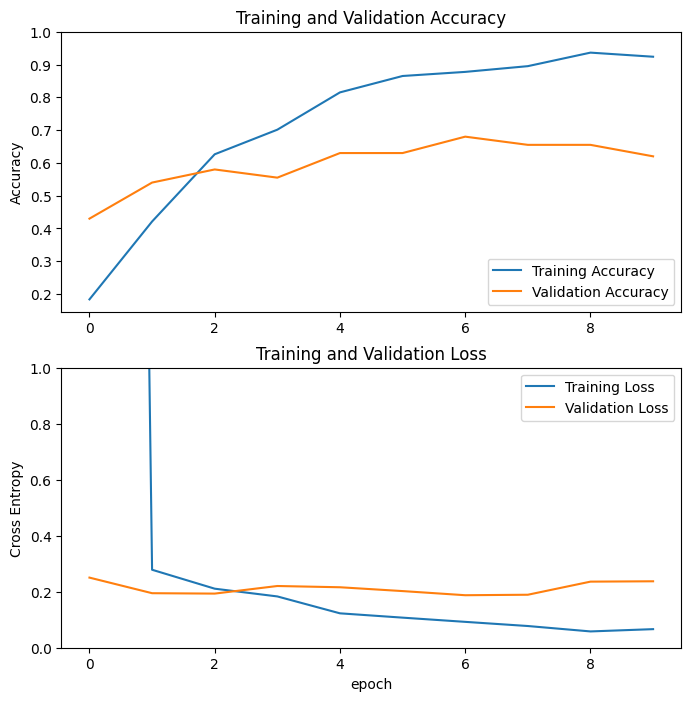

In [76]:
# Affichage de l'évolution du modèle avant la data augmentation et le transfert learning
plot_model_evolution(history)

In [ ]:
"""
print('•\tData augmentation')
data_augmentation(images)
print('•\tData augmentation: OK')
"""

In [73]:
print('•\tCNN Model on Wang images AFTER DATA AUGMENTATION')
# Load the images and their corresponding labels
image_folder_augmentation = 'C:/Users/ELE5f76370fc459a/Desktop/Machine-Learning-projects/Reseaux de neurones/Wang_Data_Augmentation'
images, images_labels, model_augmentation, X_train_augmentation, y_train_augmentation, X_test_augmentation, y_test_augmentation, history_augmentation = cnn_model_wang_images(image_folder_augmentation, '.png', epochs=10)
model_augmentation.save('model_wang_data_augmentation.h5')
print('•\tCNN Model on Wang images AFTER DATA AUGMENTATION: OK')

•	CNN Model on Wang images AFTER DATA AUGMENTATION
	○	Shapes of training and testing datasets
(7200, 256, 256, 3) (1800, 256, 256, 3) (7200, 11) (1800, 11)
	○	Model Summary
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (C

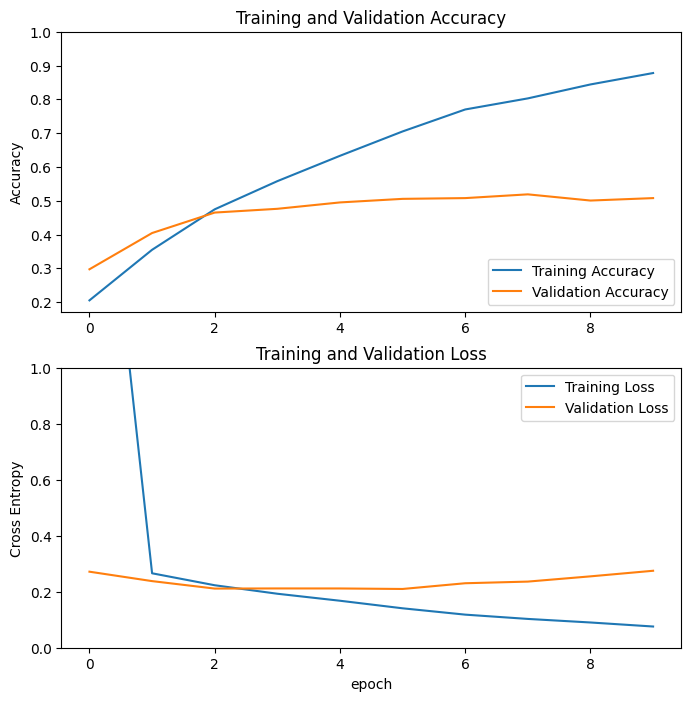

In [74]:
# Affichage de l'évolution du modèle avant la data augmentation et le transfert learning
plot_model_evolution(history_augmentation)

In [72]:
print('•\tCNN Model with Transfert Learning')
# Load the images and their corresponding labels
image_folder_augmentation = 'C:/Users/ELE5f76370fc459a/Desktop/Machine-Learning-projects/Reseaux de neurones/Wang_Data_Augmentation'
num_classes = 11
new_model, model_info, history = transfert_learning(X_train_augmentation, y_train_augmentation,X_test_augmentation, y_test_augmentation, num_classes, epochs=3)
new_model.save('model_wang_transfert_learning.h5')
print('•\tCNN Model with Transfert Learning: OK')

•	CNN Model with Transfert Learning
	○	Transfert Learning avec VGG16
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                          

ValueError: in user code:

    File "C:\Users\ELE5f76370fc459a\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\ELE5f76370fc459a\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ELE5f76370fc459a\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\ELE5f76370fc459a\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\ELE5f76370fc459a\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ELE5f76370fc459a\AppData\Roaming\Python\Python310\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_7" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(32, 256, 256, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(32, 11) dtype=float32>]


In [ ]:
plot_accuracy_evolution(history)